# Ejercicio 1

En este notebook se pretende crear un sistema estocástico básico para simulaciones. La idea es encontrar el FPT de este proceso y crear un método discreto que sirva para encontrar la probabilidad de pasar el umbral establecido.

Se partirá con la creación de una clase que sea el proceso, el cual es capaz de generar números aleatorios a partir de un sistema básico determinado por una ecuación de evolución (dinámica del sistema).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
from scipy.stats import norm
import scipy.integrate as integrate
import math

Primero, hay que calcular la distribución de probabilidad del tiempo de falla de un proceso simple:

$$ x_{t+1} = k + a_1 x_t + \mu_{t+1} $$

Donde $\mu \sim N(0,\sigma)$, $k$ y $a_1$ es una constante del proceso.

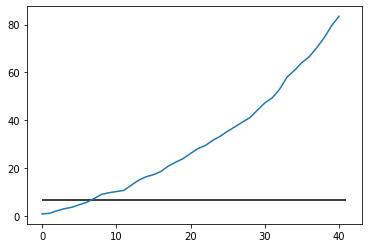

In [2]:
x_0 = 1
N = 41

proceso = np.zeros((N,))
proceso[0] = x_0
a1 = 1.05
sigma = 0.6
np.random.seed(32)
u = 7
K = 0.4

for i in range(N-1):
    
    proceso[i + 1] = K + a1 * proceso[i] + np.random.normal(0, sigma)

plt.plot(proceso)
plt.hlines(u,0,N)

A continuación se definen funciones auxiliares para calcular la media y la varianza de forma teóricas

In [3]:
def E(t, dt, x_=None):
    x = 0

    for i in range(dt): x += a1**i
    x *= K
    
    if x_ is not None: x += (a1**dt) * x_
    else: x += (a1**dt) * proceso[t]
    
    return x

def Var(t, dt, x_=None):
    x = 0
    
    for i in range(dt): x += a1**(2*i)
    
    x *= sigma**2
    
    return x


Ahora hay que correr un montecarlo para capturar la primera pasada por un umbral

0
7


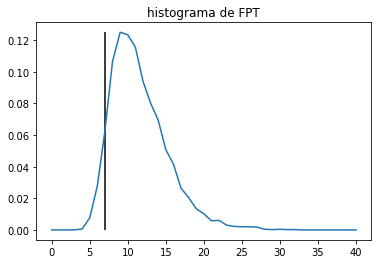

In [6]:
M = 5000 # cantidad de simulaciones
n = 0 # punto inicial donde se comienza a predecir
PROCESOS = np.zeros((M, N - n)) # simulaciones
FPT = [] # tiempos de primera pasada

### SIMULACIONES MC ###
for i in range(M):
    
    s = 0
    x = np.zeros((N - n,))
    t = np.linspace(n, N, num=N-n)
    x[0] = proceso[n]
    first_time = True
    
    for j in range(len(x) - 1):
        x[j + 1] = K + a1 * x[j] + np.random.normal(0, sigma)
        if x[j] >= u and first_time:
            FPT.append(j)
            first_time = False

    PROCESOS[i, :] = x
#     plt.plot(t, x, color='r', alpha=0.01)

### CALCULO MEDIA Y VARIANZA 
# t = np.linspace(n, N + 1, num=N-n)
# media = np.zeros((N - n,))
# varianza = np.zeros((N - n,))

# media_e = np.zeros((N - n,))
# varianza_e = np.zeros((N - n,))

# for i in range(len(x)):
    
#     # media y varianzas teoricas
#     media[i] = E(n, i)
#     varianza[i] = np.sqrt(Var(n, i))
    
#     # media y varianzas empiricas
#     media_e[i] = np.mean(PROCESOS[:,i])
#     varianza_e[i] = np.sqrt(np.var(PROCESOS[:,i]))

# plt.plot(t, media, color='g', alpha=0.6, label='$\mu, \sigma^2$ teoria')
# plt.plot(t, media + varianza, t, media - varianza, color='g', alpha=0.3)

# plt.plot(t, media_e, color='k', alpha=0.6, label='$\mu, \sigma^2$ empirica')
# plt.plot(t, media_e + varianza_e, t, media_e - varianza_e, color='k', alpha=0.3)

# plt.plot(proceso, color='b', label='proceso')
# plt.hlines(u,0,N, color='k', linestyles='dashed', label='umbral')
# plt.plot(np.where(proceso >= u)[0][0], u, '*')
# plt.plot(n, proceso[n], '*')
# # plt.ylim(bottom=0)
# plt.ylim(top=u*1.2, bottom=0)
# plt.legend(), plt.ylabel('x'), plt.xlabel('t')
# plt.title('Proceso y simulaciones MC $a_1={}, k={}, \sigma={}, u={}$'.format(a1, K, sigma, u))
# plt.show()

### CALCULO DE HISTOGRAMA ###
histograma_MC = np.zeros((N,))
x_histograma_MC = np.arange(0, N)
# print(FPT)
for f in FPT:
    histograma_MC[f] += 1

plt.plot(x_histograma_MC, histograma_MC / np.sum(histograma_MC), label='MC')
plt.title('histograma de FPT')
print(n)
print(np.where(proceso >= u)[0][0])
plt.vlines(np.where(proceso >= u)[0][0] - n, 0, np.max(histograma_MC / np.sum(histograma_MC)))
plt.show()

Ahora se debe calcular la distribución de probabilidad según el paper de referencia

Para ello se utiliza el sistema de ecuaciones expresado en el paper:

$
\left[{\begin{array}[c]\\
        Pr(a_1) \\ Pr(a_2) \\ ... \\ Pr(a_k) 
\end{array} }\right] = \Theta \times \left[{\begin{array}[c] 
    q_1 \\ q_2 \\ ... \\ q_k
\end{array}}\right]
$


Comprobar que la distribución de probabilidad de la variable dada sea la misma que la pronosticada por monte carlo. Para ello se tomará un instante arbitrario y se graficará el histograma de la variable. Además de calcular la media y la varianza de la distribución que debería resultar en aquel momento.

0.975609756097561945
 0.0

 1.0


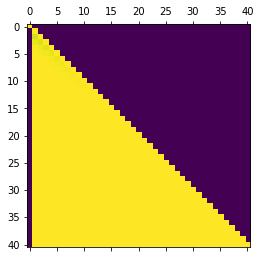

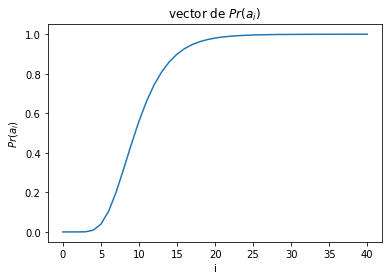

In [7]:
### DEFINICION DE INTEGRANDO PARA CALCULO DE THETA ###
def integrand(x, n, i, j):

    aux = norm.pdf( x , loc=E(n, j), scale=np.sqrt(Var(n, j) )) # bien
    aux *= 1 - norm.cdf(u, loc=E(n + i, i - j, x), scale=np.sqrt(Var(n + i, i - j, x)) )
    return aux


### CALCULO DE DISTRIBUCION DE ACUERDO AL PAPER ###
k = N - n ######################### cantidad de iteraciones
A = np.zeros((k,)) ################ vector de Pr(a)
theta = np.zeros((k,k)) ########### matriz theta

for i in range(k):
    
    A[i] = 1 - norm.cdf(u, loc=E(n,i + 1), scale=np.sqrt(Var(n,i + 1))) # bien
    
    theta[i, i] = 1
    print('\r{}'.format(i/k), end='', flush=True)
    
    for j in range(i): # i,j
        
        aux = 1 - norm.cdf(u, loc=E(n, j + 1), scale=np.sqrt(Var(n, j + 1)))
        
        ### se agrega para que no colapse el calculo, ya que si la probabilidad es nula
        ## el valor final tambien debe ser nulo, solo en el caso de que realmente sea nulo
        # fix
        if aux == 0:
            theta[i, j] = 0
        else:
            theta[i, j] = 1 / aux
            # este metodo se debe aproximar por un calculo discreto
            integral = integrate.quad(integrand, u, np.inf, args=(n, i + 1, j + 1))
            
            theta[i, j] *= integral[0]
#             theta[i, j] = 1
            
print('\n',np.min(theta))
print('\n',np.max(theta))
plt.matshow(theta)
plt.show()
plt.plot(A), plt.title('vector de $Pr(a_i)$'), plt.ylabel('$Pr(a_i)$'), plt.xlabel('i')
plt.show()

Se debe calcular la probabilidad de forma analítica con lo que entregó el profe.

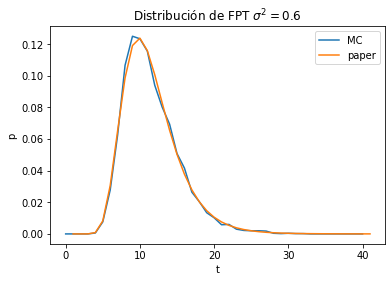

In [8]:
### CALCULO SIMPLE DE PROBABILIDAD PARA FPT ###
P_h = np.zeros((N - n,))
P_f = np.zeros((N - n,))
P = np.zeros((N - n + 1,))

P_h[0] = 1
P_f[0] = 0

for i in range(1,N - n):
    P_f[i] = norm.cdf((media[i] - u) / np.sqrt(varianza[i]))
    P_h[i] = (1 - P_f[i - 1]) * P_h[i - 1]
    P[i] = P_f[i] * P_h[i]
P[len(P) - 1] = 1 - np.sum(P[: len(P) - 1])

### CALCULO DE FORMA MATRICIAL DE LA DISTRIBUCION DE PROBABILIDAD DE ACUERDO A PAPER
q = np.matmul(np.linalg.inv(theta), A)

plt.plot(x_histograma_MC, histograma_MC / np.sum(histograma_MC), label='MC')
plt.plot(np.array(range(len(q))) + 1, q, label='paper')
plt.xlabel('t')
# plt.vlines(np.where(proceso >= u)[0][0] - n, 0, np.max(q), color='r', label='FPT proceso')
# plt.plot(P, 'go', label='simple prediction')
plt.ylabel('p')
plt.title('Distribución de FPT $\sigma^2 =${}'.format(sigma))
plt.legend(loc='best')
plt.show()